# Trigram Implementation and other exercises

**E01:** Train a trigram language model, i.e., take two characters as input to predict the 3rd one.
   - Feel free to use either counting or a neural net.
   - Evaluate the loss.
   - Did it improve over a bigram model?

**E02:** Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

**E03:** Use the dev set to tune the strength of smoothing (or regularization) for the trigram model.
   - Try many possibilities and see which one works best based on the dev set loss.
   - What patterns can you see in the train and dev set loss as you tune this strength?
   - Take the best setting of the smoothing and evaluate on the test set once and at the end.
   - How good of a loss do you achieve?

**E04:** We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of `F.one_hot` in favor of simply indexing into rows of W?

**E05:** Look up and use `F.cross_entropy` instead. You should achieve the same result. Can you think of why we'd prefer to use `F.cross_entropy` instead?

**E06:** Meta-exercise! Think of a fun/interesting exercise and complete it.


In [ ]:
import math

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F


%matplotlib inline

In [ ]:
words = open('names.txt', 'r').read().splitlines()

In [ ]:
words[:10]

In [ ]:
t = {}
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        trigram = (ch1+ch2, ch3)
        t[trigram] = t.get(trigram, 0) + 1

In [ ]:
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {s:i for i, s in enumerate(chars)}
# stoi['.'] = 0
itos = {i:s for s, i in stoi.items()} # could use enum(chars) but <.> will be missed

bichars = [x+y for x in chars for y in chars]
btoi = {b:i for i, b in enumerate(bichars)}
itob = {i:b for b, i in btoi.items()}

#### Counting model

In [ ]:
# N = torch.zeros((27, 27, 27), dtype=torch.int32)
# for w in words:
#     chs = ['.'] + list(w) + ['.']
#     for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
#         ix1 = stoi[ch1]
#         ix2 = stoi[ch2]
#         ix3 = stoi[ch3]
#         N[ix1, ix2, ix3] += 1

N = torch.zeros((729, 27), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = btoi[ch1+ch2]
        ix2 = stoi[ch3]
        N[ix1, ix2] += 1

In [ ]:
stoi['m']

In [ ]:
btoi['mh'] # 359
27*stoi['m'] # 338
27*stoi['m']+stoi['h'] # 359

In [ ]:
plt.figure(figsize=(16, 16))
plt.imshow(N[:27], cmap='Oranges')
for i in range(27):
    for j in range(27):
        chstr = itob[i]+itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='black')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='black')
plt.axis('off');

In [ ]:
# sanity check
za = 0
for w in words:
    za+=1 if w[:2] == 'za' else 0
za

In [ ]:
P = (N+1).float() # why 1? some counts are 0 so probab will be 0 i.e. inf loglikelihood
P /= P.sum(1, keepdim=True)

In [334]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out = []
    start_p = P[:26].view(-1)
    start_s = torch.multinomial(start_p, num_samples=1, replacement=True, generator=g).item()
    b, s = divmod(start_s, 27)
    b_next = itob[b][1]+itos[s]
    ix = btoi[b_next]
    out.append(b_next) 
    while True:
        
        p = P[ix]
        s = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        b_next = b_next[1]+itos[s]
        ix = btoi[b_next]
        if b_next[1] != '.':
            out.append(b_next[1])
        else:
            break

    print(''.join(out))

iounide
oalianah
rhyliah
ya
runa
qui
reltoper
my
gele
andannaaryanileniassibduinrwin


In [336]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = btoi[ch1+ch2]
        ix2 = stoi[ch3]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2} -> {ch3}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = - log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-410414.9688)
nll=tensor(410414.9688)
2.092747449874878


#### Neural Net

In [337]:
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = btoi[ch1+ch2]
        ix3 = stoi[ch3]
        xs.append(ix1)
        ys.append(ix3)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

xs,ys

(tensor([  5, 148, 364,  ..., 727, 701, 726]),
 tensor([13, 13,  1,  ..., 26, 24,  0]))

In [338]:
xs.shape

torch.Size([196113])

In [339]:
len(btoi)

729

In [340]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((len(btoi), 27), generator=g, requires_grad=True)

In [354]:
for k in range(1000):
    xenc = F.one_hot(xs, num_classes=len(btoi)).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)

    loss = -probs[torch.arange(probs.shape[0]), ys].log().mean()

    if k%20 == 0: 
        print(loss.item())


    W.grad = None
    loss.backward()

    W.data += -50*W.grad

2.1081671714782715
2.1074788570404053
2.1068122386932373
2.106166362762451
2.1055400371551514
2.1049325466156006
2.1043429374694824
2.1037704944610596
2.1032145023345947
2.1026742458343506
2.1021487712860107
2.101637840270996
2.1011407375335693
2.100656747817993
2.1001853942871094
2.0997262001037598
2.0992789268493652
2.0988428592681885
2.098417282104492
2.0980024337768555
2.097597360610962
2.0972018241882324
2.096815824508667
2.0964386463165283
2.0960702896118164
2.095710039138794
2.095357894897461
2.095013380050659
2.0946764945983887
2.0943470001220703
2.094024181365967
2.0937085151672363
2.0933990478515625
2.0930957794189453
2.092799425125122
2.092508316040039
2.0922234058380127
2.0919437408447266
2.0916693210601807
2.0914008617401123
2.091136932373047
2.0908780097961426
2.0906243324279785
2.0903749465942383
2.090130090713501
2.0898895263671875
2.089653253555298
2.089421510696411
2.08919358253479
2.0889697074890137


#### Train, Dev, Test Split
Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

In [360]:
batsmen = ['smith', 'babar', 'virat', 'quinton', 'stokes', 'rashid']
batsmen[:2], batsmen[2:4], batsmen[4:]

(['smith', 'babar'], ['virat', 'quinton'], ['stokes', 'rashid'])

In [378]:
train_idx = int(0.8 * len(words))
train_set = words[:train_idx]
dev_idx = train_idx + int(0.1* len(words))
dev_set = words[train_idx:dev_idx]
test_set = words[dev_idx: ]
len(train_set), len(dev_set), len(test_set)

(25626, 3203, 3204)

Test loss for this model is :2.605152


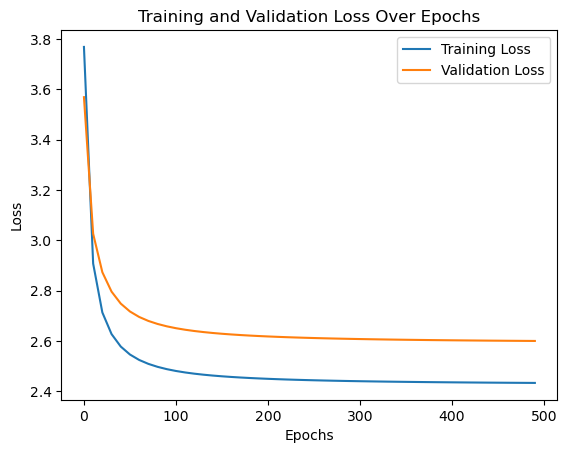

In [383]:
# bigram model - dataset

# create dataset


set_dict = {'train': train_set, 'dev': dev_set, 'test':test_set}
data_set = {}

for mode, data in set_dict.items():
    xs, ys = [], []
    for w in data:
        chs = ['.'] + list(w) + ['.']
        for ch1, ch2 in zip(chs, chs[1:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            xs.append(ix1)
            ys.append(ix2)
    data_set['xs_'+mode] = torch.tensor(xs)
    data_set['ys_'+mode] = torch.tensor(ys)


# initialize weights
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

training_loss = {}
validation_loss = {}
# train and dev
for k in range(500):

    # training
    ## forward pass
    xenc = F.one_hot(data_set['xs_train'], num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    train_loss = -probs[torch.arange(probs.shape[0]), data_set['ys_train']].log().mean()
    # print(train_loss.item())

    ## backward pass
    W.grad = None
    train_loss.backward()

    ## update
    W.data += -20 * W.grad

    # dev
    xenc = F.one_hot(data_set['xs_dev'], num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    dev_loss = -probs[torch.arange(probs.shape[0]), data_set['ys_dev']].log().mean()

    if k%10 == 0:
        # print(f'Train Loss: {train_loss.item():4f} \t Dev Loss:{dev_loss.item():4f}')
        training_loss[k] = train_loss.item()
        validation_loss[k] = dev_loss.item()

# test set
xenc = F.one_hot(data_set['xs_test'], num_classes=27).float()
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
test_loss = -probs[torch.arange(probs.shape[0]), data_set['ys_test']].log().mean()
print(f'Test loss for this model is :{test_loss.item():4f}')

# Plotting graph for train and dev
plt.plot(list(training_loss.keys()), list(training_loss.values()), label='Training Loss')
plt.plot(list(validation_loss.keys()), list(validation_loss.values()), label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')

plt.legend()
plt.show()